# Diffusion FWI Generation Notebook

This notebook demonstrates how to run diffusion-based Full Waveform Inversion (FWI) generation with and without physics-informed conditioning.

## Overview

We will:
1. Load pre-saved sample data from the `outputs_cond` directory
2. Load a trained diffusion model checkpoint
3. Run generation **without** physics conditioning (zero-shot sampling)
4. Run generation **with** physics conditioning (DPS-based sampling)
5. Compare and visualize the results


In [ ]:
# SPDX-FileCopyrightText: Copyright (c) 2023 - 2025 NVIDIA CORPORATION & AFFILIATES.
# SPDX-FileCopyrightText: All rights reserved.
# SPDX-License-Identifier: Apache-2.0


## 1. Setup and Imports


In [ ]:
import sys
import os
from pathlib import Path
from functools import partial

# Set up the working directory - use current directory (where notebook is located)
# This makes the notebook portable - just run from the lab_4 directory
NOTEBOOK_DIR = Path.cwd()

# Add the notebook directory to sys.path for local imports (utils/)
if str(NOTEBOOK_DIR) not in sys.path:
    sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"Working directory: {NOTEBOOK_DIR}")
print(f"Note: Make sure physicsnemo is installed (pip install physicsnemo)")

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from einops import repeat, rearrange

# PhysicsNeMo imports
from physicsnemo import Module

# StackedRandomGenerator - try importing from physicsnemo, fallback to local definition
try:
    from physicsnemo.diffusion.utils import StackedRandomGenerator
except (ImportError, ModuleNotFoundError):
    # Define locally if not available in installed package
    class StackedRandomGenerator:
        """Random generator that produces same sequences for each position in a batch."""
        def __init__(self, device, seeds):
            self.generators = [torch.Generator(device=device).manual_seed(int(seed)) for seed in seeds]
        
        def randn(self, shape, device=None, dtype=torch.float32):
            if device is None:
                device = self.generators[0].device
            return torch.stack([
                torch.randn(shape[1:], generator=gen, device=device, dtype=dtype)
                for gen in self.generators
            ])
    print("Using local StackedRandomGenerator implementation")
    
    # Monkey-patch the module so utils.diffusion can import it
    import types
    diffusion_utils_module = types.ModuleType("physicsnemo.diffusion.utils")
    diffusion_utils_module.StackedRandomGenerator = StackedRandomGenerator
    diffusion_module = types.ModuleType("physicsnemo.diffusion")
    diffusion_module.utils = diffusion_utils_module
    sys.modules["physicsnemo.diffusion"] = diffusion_module
    sys.modules["physicsnemo.diffusion.utils"] = diffusion_utils_module

# Local imports from the diffusion_fwi example
from utils.preconditioning import edm_precond
from utils.diffusion import (
    DiffusionAdapter,
    ModelBasedGuidance,
    EDMStochasticSampler,
)
# Import the model class so it's registered before loading checkpoint
from utils.nn import DiffusionFWINet

# Optional: deepwave for physics-informed guidance
try:
    import deepwave
    DEEPWAVE_AVAILABLE = True
    print("Deepwave is available for physics-informed sampling")
except ImportError:
    DEEPWAVE_AVAILABLE = False
    print("Deepwave not available - physics-informed sampling will be disabled")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Working directory: /Users/hasethi/work/physicsnemo/examples/geophysics/diffusion_fwi
Using physicsnemo from: /Users/hasethi/work/physicsnemo


/Users/hasethi/anaconda3/envs/pnemo/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Deepwave is available for physics-informed sampling
PyTorch version: 2.9.1
CUDA available: False


## 2. Configuration

Set up the paths and parameters for generation.


In [3]:
# =============================================================================
# CONFIGURATION - Modify these paths as needed
# =============================================================================

# Path to the trained model checkpoint (.mdlus file)
# Using the conditional checkpoint for conditioned generation
CHECKPOINT_PATH = Path("./checkpoints/conditional/DiffusionFWINet.0.980.mdlus")
# Alternative: use the test checkpoint for quick testing:
# CHECKPOINT_PATH = Path("./tests/data/checkpoint_diffusion_fwi_net_fwi_small_gpu-v1.2.0.mdlus")

# Path to the pre-saved sample data
SAMPLES_DIR = Path("./outputs_cond")

# Output directory for new generation results
OUTPUT_DIR = Path("./outputs_notebook")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generation parameters
NUM_ENSEMBLES = 8  # Number of ensemble members to generate
SEED_BATCH_SIZE = 2  # Batch size for generation
GLOBAL_SEED = 42  # Random seed for reproducibility

# Sampler parameters
NUM_STEPS = 20  # Number of diffusion steps
SIGMA_MIN = 0.002
SIGMA_MAX = 80.0

# Physics-informed guidance parameters
PI_GUIDANCE_CONFIG = {
    "std": 0.01,
    "gamma": 0.01,
    "scale": 0.1,
    "power": 2.0,
    "norm_ord": 1,
    "magnitude_scaling": True,
    "source_frequency": 15,
}

# Dataset configuration (must match the training configuration)
X_VARS = ["vp", "vs", "rho"]  # Velocity model variables
Y_VARS = ["vx", "vz"]  # Seismic observation variables
X_RESOLUTION = (80, 80)  # Spatial resolution of velocity model
Y_RESOLUTION = (1000, 80)  # Resolution of seismic data (time, receivers)
NB_SHOTS = 5  # Number of sources/shots

print(f"Device: {DEVICE}")
print(f"Checkpoint: {CHECKPOINT_PATH}")
print(f"Samples directory: {SAMPLES_DIR}")
print(f"Output directory: {OUTPUT_DIR}")


Device: cpu
Checkpoint: checkpoints/conditional/DiffusionFWINet.0.980.mdlus
Samples directory: outputs_cond
Output directory: outputs_notebook


## 3. Load Sample Data

Load the pre-saved sample data from the `outputs_cond` directory.


In [6]:
def load_sample_data(sample_dir: Path) -> dict:
    """
    Load sample data from a saved numpy file.
    
    Parameters
    ----------
    sample_dir : Path
        Path to the sample directory containing numpy/data.npz
        
    Returns
    -------
    dict
        Dictionary containing the loaded data
    """
    npz_path = sample_dir / "numpy" / "data.npz"
    if not npz_path.exists():
        raise FileNotFoundError(f"Data file not found: {npz_path}")
    
    data = dict(np.load(npz_path))
    return data


# List available samples
sample_dirs = sorted([d for d in SAMPLES_DIR.iterdir() if d.is_dir() and d.name.startswith("sample_")])
print(f"Found {len(sample_dirs)} samples:")
for d in sample_dirs:
    print(f"  - {d.name}")


Found 5 samples:
  - sample_0
  - sample_1
  - sample_2
  - sample_3
  - sample_4


In [7]:
# Load the first sample to inspect
sample_idx = 0
sample_data = load_sample_data(sample_dirs[sample_idx])

print(f"\nLoaded sample_{sample_idx}:")
print("Keys and shapes:")
for key, value in sample_data.items():
    print(f"  {key}: {value.shape}")



Loaded sample_0:
Keys and shapes:
  vp_pred: (16, 1, 80, 80)
  vp_true: (1, 1, 80, 80)
  vp_mean: (1, 1, 80, 80)
  vp_std: (1, 1, 80, 80)
  vp_ensemble: (16, 1, 80, 80)
  vs_pred: (16, 1, 80, 80)
  vs_true: (1, 1, 80, 80)
  vs_mean: (1, 1, 80, 80)
  vs_std: (1, 1, 80, 80)
  vs_ensemble: (16, 1, 80, 80)
  rho_pred: (16, 1, 80, 80)
  rho_true: (1, 1, 80, 80)
  rho_mean: (1, 1, 80, 80)
  rho_std: (1, 1, 80, 80)
  rho_ensemble: (16, 1, 80, 80)
  vx: (1, 5, 1000, 80)
  vz: (1, 5, 1000, 80)


In [8]:
# Extract the seismic observations (input to the model)
# These are the conditioning variables y = [vx, vz]
vx_input = torch.from_numpy(sample_data["vx"]).float()  # (1, nb_shots, T, W)
vz_input = torch.from_numpy(sample_data["vz"]).float()  # (1, nb_shots, T, W)

# Combine into conditioning tensor
y_cond = torch.cat([vx_input, vz_input], dim=1)  # (1, 2*nb_shots, T, W)
print(f"Conditioning tensor shape: {y_cond.shape}")

# Extract ground truth velocity model
vp_true = torch.from_numpy(sample_data["vp_true"]).float()
vs_true = torch.from_numpy(sample_data["vs_true"]).float()
rho_true = torch.from_numpy(sample_data["rho_true"]).float()

print(f"Ground truth shapes: vp={vp_true.shape}, vs={vs_true.shape}, rho={rho_true.shape}")


Conditioning tensor shape: torch.Size([1, 10, 1000, 80])
Ground truth shapes: vp=torch.Size([1, 1, 80, 80]), vs=torch.Size([1, 1, 80, 80]), rho=torch.Size([1, 1, 80, 80])


## 4. Visualize Input Data


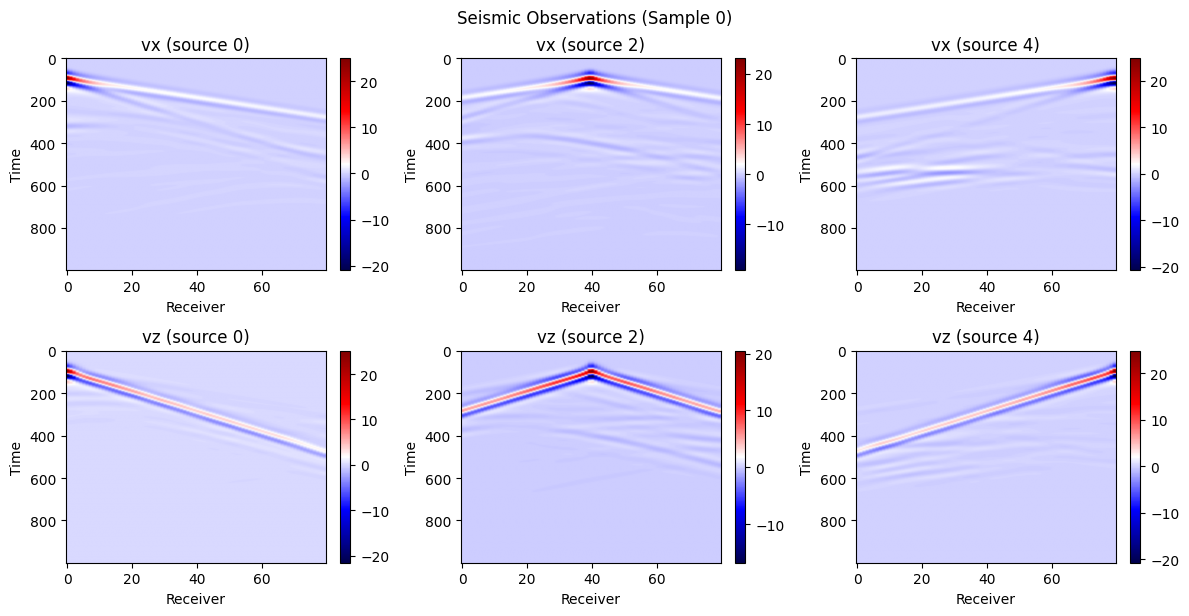

In [9]:
def plot_seismic_inputs(vx: np.ndarray, vz: np.ndarray, sources_to_plot: int = 3):
    """
    Plot the seismic input wavefields.
    
    Parameters
    ----------
    vx : np.ndarray
        Horizontal velocity component (nb_shots, T, W)
    vz : np.ndarray
        Vertical velocity component (nb_shots, T, W)
    sources_to_plot : int
        Number of sources to plot
    """
    nb_sources = vx.shape[0]
    source_indices = np.linspace(0, nb_sources - 1, min(sources_to_plot, nb_sources), dtype=int)
    
    fig, axes = plt.subplots(2, len(source_indices), figsize=(4 * len(source_indices), 6))
    if len(source_indices) == 1:
        axes = axes.reshape(2, 1)
    
    for j, src_idx in enumerate(source_indices):
        # Plot vx
        im = axes[0, j].imshow(vx[src_idx], cmap="seismic", aspect="auto")
        axes[0, j].set_title(f"vx (source {src_idx})")
        axes[0, j].set_xlabel("Receiver")
        axes[0, j].set_ylabel("Time")
        plt.colorbar(im, ax=axes[0, j], fraction=0.046)
        
        # Plot vz
        im = axes[1, j].imshow(vz[src_idx], cmap="seismic", aspect="auto")
        axes[1, j].set_title(f"vz (source {src_idx})")
        axes[1, j].set_xlabel("Receiver")
        axes[1, j].set_ylabel("Time")
        plt.colorbar(im, ax=axes[1, j], fraction=0.046)
    
    plt.tight_layout()
    return fig


# Plot seismic inputs
fig = plot_seismic_inputs(
    sample_data["vx"][0],  # Remove batch dimension
    sample_data["vz"][0],
    sources_to_plot=3
)
plt.suptitle(f"Seismic Observations (Sample {sample_idx})", y=1.02)
plt.show()


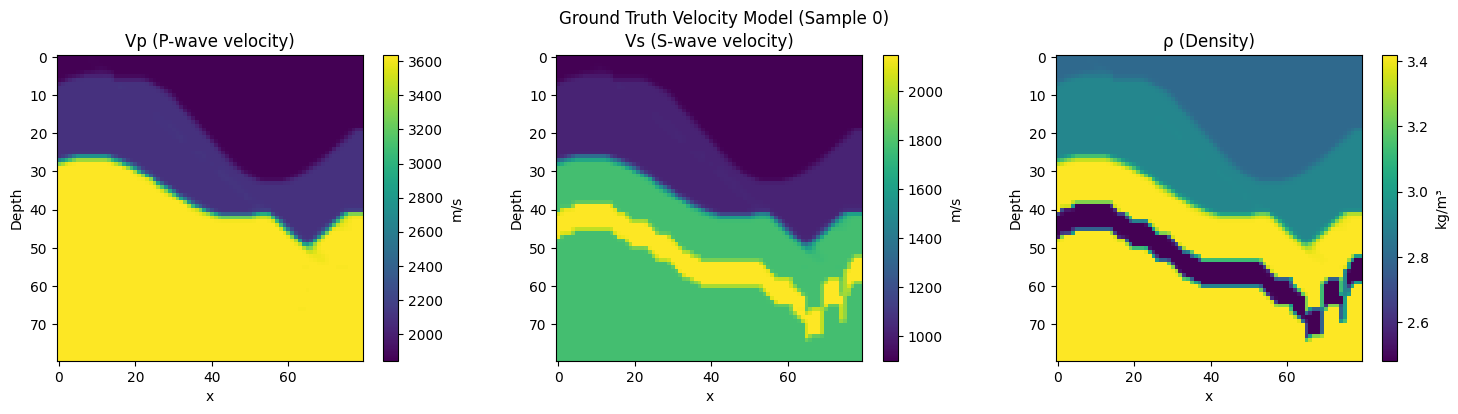

In [ ]:
def plot_velocity_model(vp: np.ndarray, vs: np.ndarray, rho: np.ndarray, title: str = "Velocity Model"):
    """
    Plot the velocity model components.
    
    Parameters
    ----------
    vp : np.ndarray
        P-wave velocity
    vs : np.ndarray
        S-wave velocity
    rho : np.ndarray
        Density
    title : str
        Plot title
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    im0 = axes[0].imshow(vp.squeeze(), cmap="viridis", aspect="auto", origin="upper")
    axes[0].set_title("Vp (P-wave velocity)")
    cbar0 = plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    cbar0.set_label("m/s")
    
    im1 = axes[1].imshow(vs.squeeze(), cmap="viridis", aspect="auto", origin="upper")
    axes[1].set_title("Vs (S-wave velocity)")
    cbar1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    cbar1.set_label("m/s")
    
    im2 = axes[2].imshow(rho.squeeze(), cmap="viridis", aspect="auto", origin="upper")
    axes[2].set_title("ρ (Density)")
    cbar2 = plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    cbar2.set_label("kg/m³")
    
    for ax in axes:
        ax.set_xlabel("x (grid)")
        ax.set_ylabel("Depth (grid)")
    
    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    return fig


# Plot ground truth velocity model
fig = plot_velocity_model(
    sample_data["vp_true"][0, 0],
    sample_data["vs_true"][0, 0],
    sample_data["rho_true"][0, 0],
    title=f"Ground Truth Velocity Model (Sample {sample_idx})"
)
plt.show()


## 5. Load Diffusion Model


In [10]:
# Load the diffusion model from checkpoint
print(f"Loading model from: {CHECKPOINT_PATH}")

if not CHECKPOINT_PATH.exists():
    print(f"\n⚠ Checkpoint not found at {CHECKPOINT_PATH}")
    print("Please update CHECKPOINT_PATH to point to a valid .mdlus checkpoint file.")
    print("\nAvailable test checkpoints:")
    test_dir = Path("./tests/data")
    if test_dir.exists():
        for f in test_dir.glob("*.mdlus"):
            print(f"  - {f}")
    diffusion_net = None
else:
    try:
        diffusion_net = Module.from_checkpoint(str(CHECKPOINT_PATH))
        diffusion_net = diffusion_net.eval().to(DEVICE)
        print(f"✓ Model loaded successfully!")
        print(f"  Model type: {diffusion_net.__class__.__name__}")
        print(f"  Parameters: {diffusion_net.num_parameters():,}")
    except Exception as e:
        print(f"✗ Error loading model: {e}")
        diffusion_net = None


Loading model from: checkpoints/conditional/DiffusionFWINet.0.980.mdlus
✓ Model loaded successfully!
  Model type: DiffusionFWINet
  Parameters: 82,737,627


In [11]:
# Create the diffusion adapter and sampler
if diffusion_net is not None:
    # Wrap the model with the diffusion adapter
    model = DiffusionAdapter(
        model=diffusion_net,
        args_map=("x", "sigma", {"y": "y"}),
    )
    
    # Create EDM preconditioning wrapper
    model_fn = partial(edm_precond, model, sigma_data=0.5)
    
    # Create the sampler
    sampler = EDMStochasticSampler(
        model=model_fn,
        num_steps=NUM_STEPS,
        sigma_min=SIGMA_MIN,
        sigma_max=SIGMA_MAX,
    )
    
    print("✓ Sampler created successfully!")
else:
    print("⚠ Skipping sampler creation - model not loaded")


✓ Sampler created successfully!


## 6. Generation Helper Functions


In [12]:
def generate_samples(
    sampler: EDMStochasticSampler,
    y_cond: torch.Tensor,
    num_ensembles: int,
    seed_batch_size: int,
    x_channels: int,
    x_resolution: tuple,
    device: torch.device,
    global_seed: int = 0,
    guidance: ModelBasedGuidance = None,
) -> torch.Tensor:
    """
    Generate ensemble samples using the diffusion model.
    
    Parameters
    ----------
    sampler : EDMStochasticSampler
        The diffusion sampler
    y_cond : torch.Tensor
        Conditioning tensor (seismic observations)
    num_ensembles : int
        Number of ensemble members to generate
    seed_batch_size : int
        Batch size for generation
    x_channels : int
        Number of channels in the output
    x_resolution : tuple
        Spatial resolution of the output
    device : torch.device
        Device to run generation on
    global_seed : int
        Random seed for reproducibility
    guidance : ModelBasedGuidance, optional
        Physics-informed guidance (if None, zero-shot sampling)
        
    Returns
    -------
    torch.Tensor
        Generated samples of shape (num_ensembles, x_channels, H, W)
    """
    # Set random seed
    torch.manual_seed(global_seed)
    np.random.seed(global_seed)
    
    # Create seed batches
    seeds = list(range(num_ensembles))
    num_batches = (len(seeds) - 1) // seed_batch_size + 1
    all_batches = [seeds[i * seed_batch_size:(i + 1) * seed_batch_size] for i in range(num_batches)]
    
    # Expand conditioning to batch size
    y_expanded = y_cond.expand(seed_batch_size, -1, -1, -1).to(
        device=device, memory_format=torch.channels_last
    )
    
    # Prepare sampler kwargs
    if guidance is not None:
        sampler_kwargs = {
            "guidance": guidance,
            "guidance_args": (y_expanded,),
        }
        torch_ctx = torch.no_grad  # Need gradients for physics guidance
    else:
        sampler_kwargs = {}
        torch_ctx = torch.inference_mode
    
    # Generate samples
    x_generated = []
    with torch_ctx():
        for batch_idx, batch_seeds in enumerate(all_batches):
            B = len(batch_seeds)
            if B == 0:
                continue
            
            print(f"  Generating batch {batch_idx + 1}/{len(all_batches)} (seeds {batch_seeds})...")
            
            # Initialize random generator
            rnd = StackedRandomGenerator(device, batch_seeds)
            x_T = rnd.randn(
                (B, x_channels) + x_resolution,
                device=device,
            ).to(memory_format=torch.channels_last)
            
            # Adjust conditioning batch size if needed
            y_batch = y_expanded[:B] if B < seed_batch_size else y_expanded
            
            # Update guidance args for this batch
            if guidance is not None:
                sampler_kwargs["guidance_args"] = (y_batch,)
            
            # Run sampler
            x_0 = sampler(x_T, {"y": y_batch}, **sampler_kwargs)
            x_generated.append(x_0.cpu())
    
    return torch.cat(x_generated, dim=0)


In [14]:
def create_wave_operator(stats_mean: dict, stats_std: dict, config: dict):
    """
    Create the wave operator for physics-informed guidance.
    
    Parameters
    ----------
    stats_mean : dict
        Mean statistics for denormalization
    stats_std : dict
        Standard deviation statistics for denormalization
    config : dict
        Configuration dictionary with physics parameters
        
    Returns
    -------
    Callable
        Wave operator function
    """
    if not DEEPWAVE_AVAILABLE:
        raise ImportError("deepwave is required for physics-informed guidance")
    
    def wave_operator(x: torch.Tensor) -> torch.Tensor:
        def smooth_clamp(x: torch.Tensor, min_val: float, max_val: float) -> torch.Tensor:
            x_scaled = torch.sigmoid(x)
            return min_val + (max_val - min_val) * x_scaled
        
        B = x.shape[0]
        x_vars = torch.split(x, 1, dim=1)
        vars_names = X_VARS
        vp = x_vars[vars_names.index("vp")].squeeze(1)
        vs = x_vars[vars_names.index("vs")].squeeze(1)
        rho = x_vars[vars_names.index("rho")].squeeze(1)
        
        # Denormalize
        vp = stats_mean["vp"] + stats_std["vp"] * vp
        vs = stats_mean["vs"] + stats_std["vs"] * vs
        rho = stats_mean["rho"] + stats_std["rho"] * rho
        
        # Define geometry
        dx = 5.0 * 7 / 8
        nt = Y_RESOLUTION[0]
        dt = 0.001
        freq = config["source_frequency"]
        peak_time = 1.5 / freq
        n_shots = NB_SHOTS
        source_depth = 1
        receiver_depth = 1
        n_receivers_per_shot = Y_RESOLUTION[1] - 1
        
        # Set sources and receivers
        source_locations = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=x.device)
        source_locations[..., 0] = source_depth
        source_locations[:, 0, 1] = torch.arange(n_shots) * 17 * 8 // 7
        
        receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=x.device)
        receiver_locations[..., 0] = receiver_depth
        receiver_locations[:, :, 1] = torch.arange(n_receivers_per_shot).repeat(n_shots, 1)
        
        source_amplitudes = (
            deepwave.wavelets.ricker(freq, nt, dt, peak_time)
            .repeat(n_shots, 1, 1)
            .to(x.device)
            * 100000.0
        )
        
        # Re-batch
        source_locations = repeat(source_locations, "Ns u v -> (B Ns) u v", B=B)
        receiver_locations = repeat(receiver_locations, "Ns Nr v -> (B Ns) Nr v", B=B)
        source_amplitudes = repeat(source_amplitudes, "Ns u Nt -> (B Ns) u Nt", B=B)
        vp = repeat(vp, "B H W -> (B Ns) H W", Ns=n_shots)
        vs = repeat(vs, "B H W -> (B Ns) H W", Ns=n_shots)
        rho = repeat(rho, "B H W -> (B Ns) H W", Ns=n_shots)
        
        # Run forward wave PDE
        out = {}
        out["vz"], out["vx"] = deepwave.elastic(
            *deepwave.common.vpvsrho_to_lambmubuoyancy(vp, vs, rho),
            grid_spacing=dx,
            dt=dt,
            source_amplitudes_y=source_amplitudes,
            source_amplitudes_x=source_amplitudes,
            source_locations_y=source_locations,
            source_locations_x=source_locations,
            receiver_locations_y=receiver_locations,
            receiver_locations_x=receiver_locations,
            pml_freq=freq,
            pml_width=[20, 20, 20, 20],
        )[-2:]
        
        y = torch.cat(
            [rearrange(out[var], "(B Ns) H W -> B Ns H W", B=B, Ns=n_shots) for var in Y_VARS],
            dim=1,
        ).transpose(3, 2)
        
        # Pad if needed
        if y.shape[-1] != Y_RESOLUTION[1]:
            pad_r = Y_RESOLUTION[1] - y.shape[-1]
            y = torch.nn.functional.pad(y, pad=(0, pad_r))
        
        return y
    
    return wave_operator


## 7. Run Generation WITHOUT Physics Conditioning (Zero-Shot)

This is purely data-driven sampling from the learned conditional distribution.


In [12]:
if diffusion_net is not None:
    print("=" * 60)
    print("ZERO-SHOT SAMPLING (No Physics Conditioning)")
    print("=" * 60)
    
    # Generate samples without physics guidance
    print(f"\nGenerating {NUM_ENSEMBLES} ensemble members...")
    
    x_pred_no_physics = generate_samples(
        sampler=sampler,
        y_cond=y_cond,
        num_ensembles=NUM_ENSEMBLES,
        seed_batch_size=SEED_BATCH_SIZE,
        x_channels=len(X_VARS),
        x_resolution=X_RESOLUTION,
        device=DEVICE,
        global_seed=GLOBAL_SEED,
        guidance=None,  # No physics guidance
    )
    
    print(f"\n✓ Generated samples shape: {x_pred_no_physics.shape}")
else:
    print("Skipping generation - model not loaded")
    x_pred_no_physics = None


ZERO-SHOT SAMPLING (No Physics Conditioning)

Generating 8 ensemble members...
  Generating batch 1/4 (seeds [0, 1])...
  Generating batch 2/4 (seeds [2, 3])...
  Generating batch 3/4 (seeds [4, 5])...
  Generating batch 4/4 (seeds [6, 7])...

✓ Generated samples shape: torch.Size([8, 3, 80, 80])


## 8. Run Generation WITH Physics Conditioning (DPS)

This uses Diffusion Posterior Sampling with physics-informed guidance based on the wave equation.


In [15]:
if diffusion_net is not None and DEEPWAVE_AVAILABLE:
    print("=" * 60)
    print("PHYSICS-INFORMED SAMPLING (DPS with Wave Equation)")
    print("=" * 60)
    
    # For physics-informed guidance, we need normalization statistics
    # These should match what was used during training
    # Using approximate values - update these with your actual statistics
    stats_mean = {
        "vp": 3000.0,  # Approximate mean P-wave velocity (m/s)
        "vs": 1700.0,  # Approximate mean S-wave velocity (m/s)
        "rho": 2200.0,  # Approximate mean density (kg/m³)
    }
    stats_std = {
        "vp": 800.0,  # Approximate std P-wave velocity
        "vs": 500.0,  # Approximate std S-wave velocity
        "rho": 300.0,  # Approximate std density
    }
    
    print("\nUsing normalization statistics:")
    print(f"  Mean: {stats_mean}")
    print(f"  Std: {stats_std}")
    print("\n⚠ Note: Update these values with your actual dataset statistics!")
    
    # Create wave operator
    wave_operator = create_wave_operator(stats_mean, stats_std, PI_GUIDANCE_CONFIG)
    
    # Create physics-informed guidance
    physics_guidance = ModelBasedGuidance(
        guide_model=wave_operator,
        std=PI_GUIDANCE_CONFIG["std"],
        gamma=PI_GUIDANCE_CONFIG["gamma"],
        scale=PI_GUIDANCE_CONFIG["scale"],
        power=PI_GUIDANCE_CONFIG["power"],
        norm_ord=PI_GUIDANCE_CONFIG["norm_ord"],
        magnitude_scaling=PI_GUIDANCE_CONFIG["magnitude_scaling"],
    )
    
    print(f"\nGenerating {NUM_ENSEMBLES} ensemble members with physics guidance...")
    print("(This may take longer due to PDE evaluations)")
    
    x_pred_with_physics = generate_samples(
        sampler=sampler,
        y_cond=y_cond,
        num_ensembles=NUM_ENSEMBLES,
        seed_batch_size=SEED_BATCH_SIZE,
        x_channels=len(X_VARS),
        x_resolution=X_RESOLUTION,
        device=DEVICE,
        global_seed=GLOBAL_SEED,
        guidance=physics_guidance,
    )
    
    print(f"\n✓ Generated samples shape: {x_pred_with_physics.shape}")
    
elif diffusion_net is not None and not DEEPWAVE_AVAILABLE:
    print("⚠ Skipping physics-informed generation - deepwave not available")
    print("  Install deepwave with: pip install deepwave>=0.0.21")
    x_pred_with_physics = None
else:
    print("⚠ Skipping generation - model not loaded")
    x_pred_with_physics = None


PHYSICS-INFORMED SAMPLING (DPS with Wave Equation)

Using normalization statistics:
  Mean: {'vp': 3000.0, 'vs': 1700.0, 'rho': 2200.0}
  Std: {'vp': 800.0, 'vs': 500.0, 'rho': 300.0}

⚠ Note: Update these values with your actual dataset statistics!

Generating 8 ensemble members with physics guidance...
(This may take longer due to PDE evaluations)
  Generating batch 1/4 (seeds [0, 1])...
  Generating batch 2/4 (seeds [2, 3])...
  Generating batch 3/4 (seeds [4, 5])...
  Generating batch 4/4 (seeds [6, 7])...

✓ Generated samples shape: torch.Size([8, 3, 80, 80])


## 8.5 Well Log Conditioning (Data Consistency Guidance)

In geophysics, we often have **well log data** - measurements taken along vertical boreholes that provide ground truth velocity/density values at specific locations. We can condition our diffusion generation to honor these known values using **Data Consistency Guidance**.

### How it Works

Well log conditioning uses the same DPS (Diffusion Posterior Sampling) framework as physics conditioning, but with a different forward model:

1. **Create a mask**: Binary mask indicating where well data exists (e.g., a vertical column at x=32)
2. **Provide ground truth**: The known velocity values at the well location
3. **Guide the sampling**: At each denoising step, the guidance term penalizes deviations from the known well values

The guidance computes:
$$\nabla_{\mathbf{x}_t} \log p(\mathbf{y}_{well} | \hat{\mathbf{x}}_0) \propto -\frac{\partial}{\partial \mathbf{x}_t} \| \text{mask} \odot (\hat{\mathbf{x}}_0 - \mathbf{y}_{well}) \|^2$$

This is similar to **inpainting** but done through gradient guidance rather than direct replacement.

In [13]:
# =============================================================================
# WELL LOG CONDITIONING - Simple Functions
# =============================================================================

def create_well_mask(well_positions, height, width):
    """Create binary mask for well locations (vertical columns)."""
    mask = torch.zeros(1, 1, height, width)
    for x in well_positions:
        if 0 <= x < width:
            mask[:, :, :, x] = 1.0
    return mask

def apply_well_constraint(x, mask, gt_normalized, sigma):
    """
    Apply well constraint by replacing well pixels with noised ground truth.
    Simple inpainting approach - works at each diffusion step.
    """
    noise = torch.randn_like(gt_normalized)
    sigma_val = sigma.item() if isinstance(sigma, torch.Tensor) else sigma
    gt_noised = gt_normalized + sigma_val * noise
    return torch.where(mask.expand_as(x) > 0, gt_noised.expand_as(x), x)

def normalize_velocity(vp, vs, rho, stats_mean, stats_std):
    """Normalize velocity model to zero mean, unit variance."""
    vp_norm = (torch.tensor(vp, dtype=torch.float32) - stats_mean['vp']) / stats_std['vp']
    vs_norm = (torch.tensor(vs, dtype=torch.float32) - stats_mean['vs']) / stats_std['vs']
    rho_norm = (torch.tensor(rho, dtype=torch.float32) - stats_mean['rho']) / stats_std['rho']
    return torch.stack([vp_norm, vs_norm, rho_norm], dim=0).unsqueeze(0)

print("✓ Simple well log functions defined:")
print("  create_well_mask(positions, H, W)")
print("  apply_well_constraint(x, mask, gt, sigma)")
print("  normalize_velocity(vp, vs, rho, mean, std)")


✓ Simple well log functions defined:
  create_well_mask(positions, H, W)
  apply_well_constraint(x, mask, gt, sigma)
  normalize_velocity(vp, vs, rho, mean, std)


Wells at x = [20, 40, 60]
Mask shape: torch.Size([1, 1, 80, 80]), GT shape: torch.Size([1, 3, 80, 80])


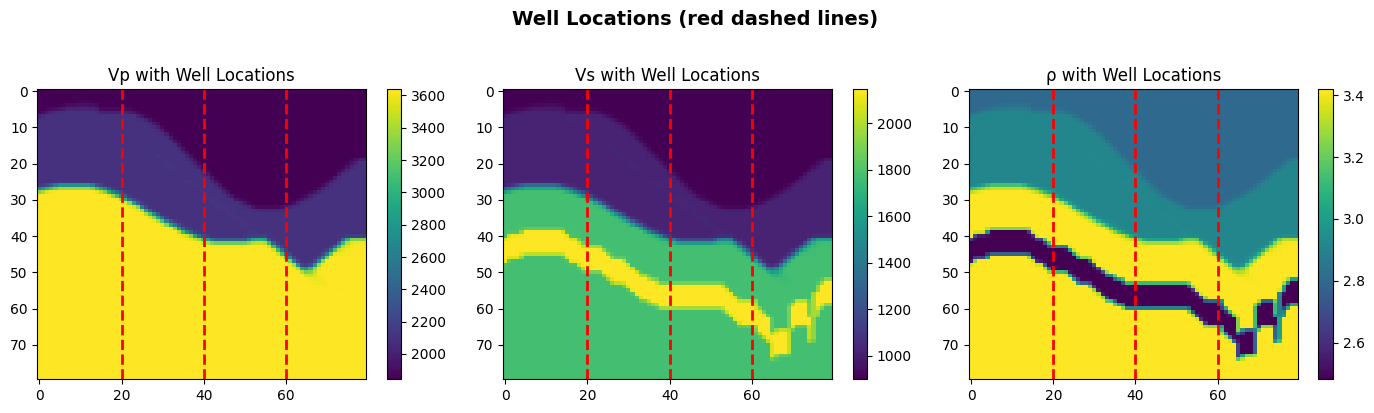

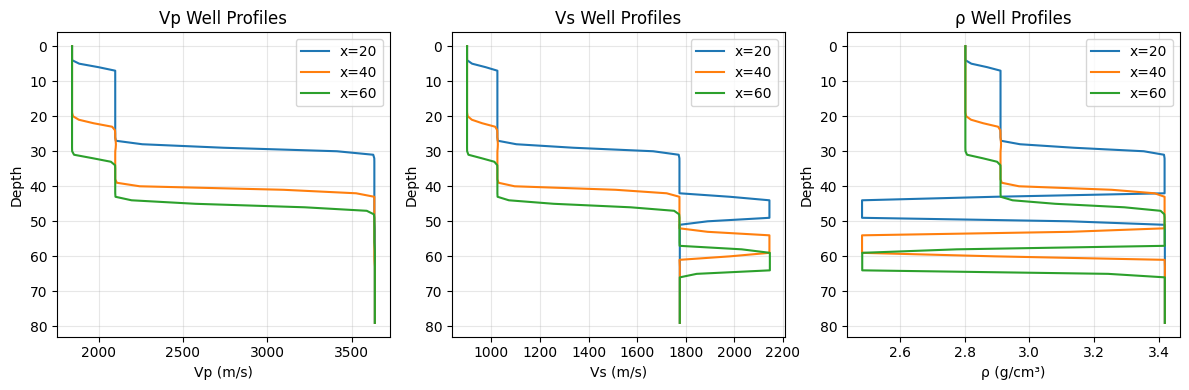

In [14]:
# =============================================================================
# WELL LOG DEMO - Visualize well locations and constraint effect
# =============================================================================

# Load data
data = np.load('./outputs_cond/sample_0/numpy/data.npz')
vp_true, vs_true, rho_true = data['vp_true'].squeeze(), data['vs_true'].squeeze(), data['rho_true'].squeeze()

# Well positions
WELLS = [20, 40, 60]
H, W = vp_true.shape

# Create mask and normalize ground truth
mask = create_well_mask(WELLS, H, W)
stats_mean = {'vp': 2800.0, 'vs': 1500.0, 'rho': 3.0}
stats_std = {'vp': 500.0, 'vs': 400.0, 'rho': 0.3}
gt_norm = normalize_velocity(vp_true, vs_true, rho_true, stats_mean, stats_std)

print(f"Wells at x = {WELLS}")
print(f"Mask shape: {mask.shape}, GT shape: {gt_norm.shape}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, arr, title in zip(axes, [vp_true, vs_true, rho_true], ['Vp', 'Vs', 'ρ']):
    im = ax.imshow(arr, cmap='viridis', aspect='auto', origin='upper')
    for x in WELLS:
        ax.axvline(x=x, color='red', lw=2, ls='--')
    ax.set_title(f'{title} with Well Locations')
    plt.colorbar(im, ax=ax)
plt.suptitle('Well Locations (red dashed lines)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Show well profiles
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
depth = np.arange(H)
for ax, arr, title, unit in zip(axes, [vp_true, vs_true, rho_true], ['Vp', 'Vs', 'ρ'], ['m/s', 'm/s', 'g/cm³']):
    for x in WELLS:
        ax.plot(arr[:, x], depth, label=f'x={x}')
    ax.set_title(f'{title} Well Profiles')
    ax.set_xlabel(f'{title} ({unit})')
    ax.set_ylabel('Depth')
    ax.invert_yaxis()
    ax.legend()
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


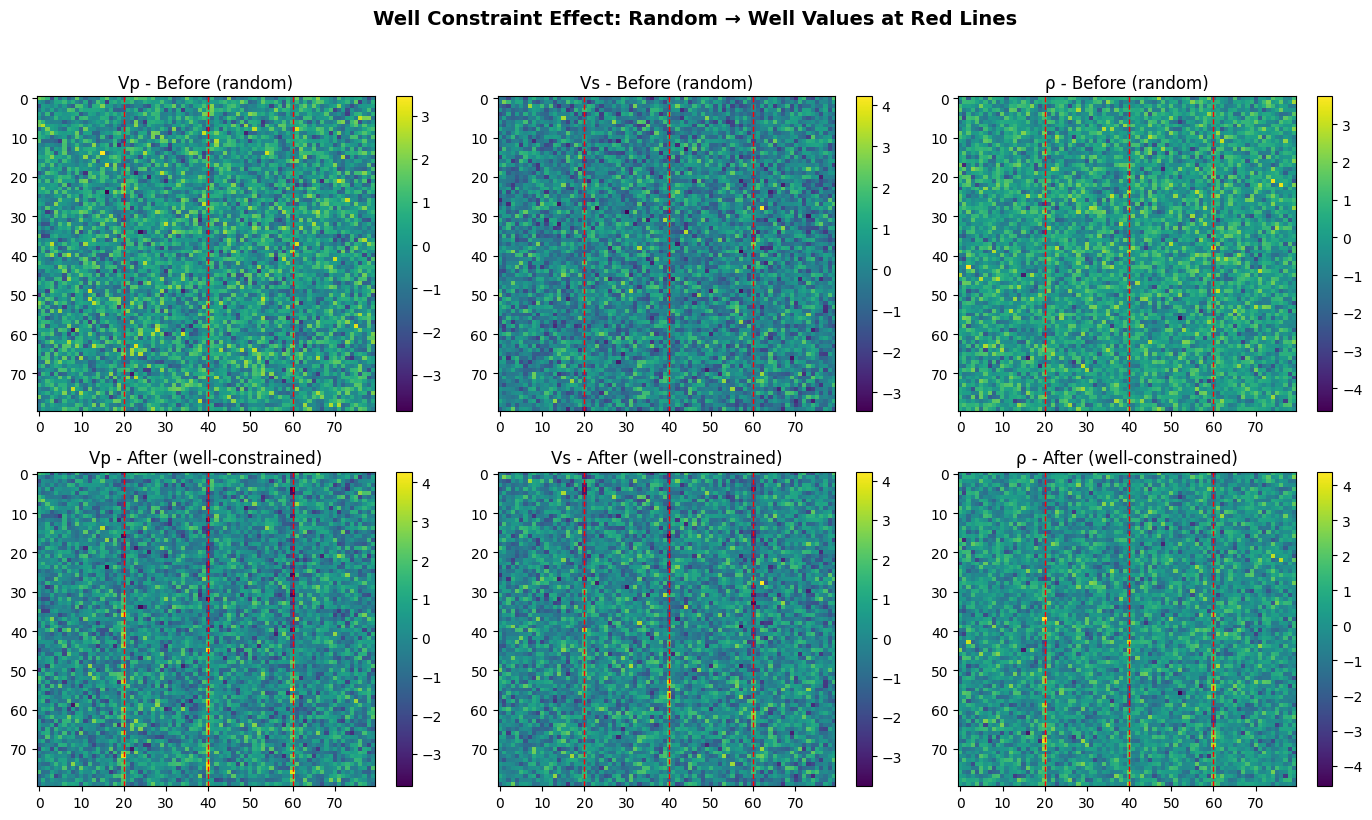


Usage in custom diffusion loop:
  for t in timesteps:
      x = denoiser(x, t)  # Normal diffusion step
      x = apply_well_constraint(x, mask, gt_norm, sigma=t)  # Apply constraint


In [15]:

# Simulate: start with random noise, apply well constraint
torch.manual_seed(42)
random_sample = torch.randn_like(gt_norm)  # Random noise (like diffusion start)
sigma = 1.0  # High noise level

# Apply constraint
constrained = apply_well_constraint(random_sample, mask, gt_norm, sigma)

# Visualize before/after
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
titles = ['Vp', 'Vs', 'ρ']

for i in range(3):
    # Before
    im = axes[0, i].imshow(random_sample[0, i].numpy(), cmap='viridis', aspect='auto')
    axes[0, i].set_title(f'{titles[i]} - Before (random)')
    for x in WELLS:
        axes[0, i].axvline(x=x, color='red', lw=1, ls='--')
    plt.colorbar(im, ax=axes[0, i])
    
    # After
    im = axes[1, i].imshow(constrained[0, i].numpy(), cmap='viridis', aspect='auto')
    axes[1, i].set_title(f'{titles[i]} - After (well-constrained)')
    for x in WELLS:
        axes[1, i].axvline(x=x, color='red', lw=1, ls='--')
    plt.colorbar(im, ax=axes[1, i])

plt.suptitle('Well Constraint Effect: Random → Well Values at Red Lines', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nUsage in custom diffusion loop:")
print("  for t in timesteps:")
print("      x = denoiser(x, t)  # Normal diffusion step")
print("      x = apply_well_constraint(x, mask, gt_norm, sigma=t)  # Apply constraint")


In [20]:
# =============================================================================
# WELL LOG CONDITIONING - Proper Guidance (Masked Loss, Full Gradient)
# =============================================================================
# Key insight: Compute loss ONLY at wells, but gradient flows to ALL pixels!

class WellLogGuidance:
    """
    Guidance that constrains well locations while affecting ALL pixels.
    
    Unlike DataConsistencyGuidance which zeros non-well regions (pushing them to 0),
    this computes loss ONLY at well locations, but the gradient naturally propagates
    to influence the entire image through the denoiser's spatial connections.
    """
    def __init__(self, scale=1.0, gamma=0.05, std=0.1):
        self.scale = scale
        self.gamma = gamma
        self.std = std
    
    def __call__(self, x, x_0_hat, sigma, y, mask):
        """
        x: noisy state (B, C, H, W)
        x_0_hat: denoised estimate (B, C, H, W)  
        sigma: noise level (B,)
        y: ground truth (B, C, H, W)
        mask: well locations (B, C, H, W), True at wells
        """
        B = x.shape[0]
        
        # Compute error ONLY at masked (well) locations
        diff = x_0_hat - y  # (B, C, H, W)
        masked_diff = diff * mask.float()  # Only error at wells, 0 elsewhere
        
        # Loss = mean squared error at well locations only
        n_wells = mask.float().sum()
        if n_wells > 0:
            loss = (masked_diff ** 2).sum() / n_wells
        else:
            return torch.zeros_like(x)
        
        # Gradient w.r.t. x (flows through denoiser to ALL pixels!)
        grad = torch.autograd.grad(loss, x, create_graph=False)[0]
        
        # Scale gradient based on noise level (less guidance at high noise)
        var = self.std**2 + self.gamma * sigma.view(B, 1, 1, 1)**2
        grad_scaled = -self.scale * grad / var
        
        # Magnitude normalization to prevent explosion
        grad_mag = grad_scaled.abs().mean()
        if grad_mag > 0:
            grad_scaled = grad_scaled / (1 + grad_mag)
        
        return grad_scaled

if diffusion_net is not None:
    print('=' * 60)
    print('WELL LOG CONDITIONING (Proper Masked Guidance)')
    print('=' * 60)
    
    # Well configuration - TUNED parameters
    WELL_POSITIONS = [20, 40, 60]
    GUIDANCE_SCALE = 0.5   # Lower = gentler guidance
    GUIDANCE_GAMMA = 0.1   # Higher = less guidance at high noise
    GUIDANCE_STD = 0.1     # Noise tolerance
    
    print(f'Well positions: x = {WELL_POSITIONS}')
    print(f'Guidance: scale={GUIDANCE_SCALE}, gamma={GUIDANCE_GAMMA}, std={GUIDANCE_STD}')
    
    # Get ground truth
    vp_gt = sample_data['vp_true'].squeeze()
    vs_gt = sample_data['vs_true'].squeeze()
    rho_gt = sample_data['rho_true'].squeeze()
    H, W = vp_gt.shape
    
    # Normalize ground truth (model works in normalized space)
    stats_mean = {'vp': 2800.0, 'vs': 1500.0, 'rho': 3.0}
    stats_std = {'vp': 600.0, 'vs': 400.0, 'rho': 0.3}
    
    vp_norm = (torch.tensor(vp_gt, dtype=torch.float32) - stats_mean['vp']) / stats_std['vp']
    vs_norm = (torch.tensor(vs_gt, dtype=torch.float32) - stats_mean['vs']) / stats_std['vs']
    rho_norm = (torch.tensor(rho_gt, dtype=torch.float32) - stats_mean['rho']) / stats_std['rho']
    
    gt_normalized = torch.stack([vp_norm, vs_norm, rho_norm], dim=0).unsqueeze(0).to(DEVICE)
    
    # Create boolean mask for well locations
    well_mask = torch.zeros(1, 3, H, W, dtype=torch.bool, device=DEVICE)
    for x_pos in WELL_POSITIONS:
        well_mask[:, :, :, x_pos] = True
    
    # Create our custom WellLogGuidance
    well_guidance = WellLogGuidance(
        scale=GUIDANCE_SCALE,
        gamma=GUIDANCE_GAMMA,
        std=GUIDANCE_STD,
    )
    
    print(f'\nGenerating with well guidance (affects ALL pixels)...')
    
    # Prepare seismic conditioning
    num_samples = 4
    vx = torch.from_numpy(sample_data['vx']).float().to(DEVICE)
    vz = torch.from_numpy(sample_data['vz']).float().to(DEVICE)
    y_seismic = torch.cat([vx, vz], dim=1).expand(num_samples, -1, -1, -1)
    
    # Expand GT and mask for batch
    y_well_batch = gt_normalized.expand(num_samples, -1, -1, -1)
    mask_batch = well_mask.expand(num_samples, -1, -1, -1)
    
    # Initialize from noise
    from physicsnemo.diffusion.utils import StackedRandomGenerator
    seeds = list(range(num_samples))
    rnd = StackedRandomGenerator(DEVICE, seeds)
    x_t = rnd.randn([num_samples, 3, H, W], device=DEVICE) * sampler.sigma_max
    
    # === CUSTOM SAMPLING LOOP WITH WELL GUIDANCE ===
    # Get sigma schedule
    num_steps = sampler.num_steps
    sigma_min, sigma_max = sampler.sigma_min, sampler.sigma_max
    rho_sched = sampler.rho
    
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=DEVICE)
    t_steps = (sigma_max ** (1/rho_sched) + step_indices / (num_steps - 1) * 
               (sigma_min ** (1/rho_sched) - sigma_max ** (1/rho_sched))) ** rho_sched
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])
    
    # Sampling loop
    for i in range(num_steps):
        t_cur = t_steps[i].float()
        t_next = t_steps[i + 1].float()
        
        # Enable gradients for guidance
        x_t = x_t.detach().requires_grad_(True)
        
        # Denoise with gradients
        x_0_hat = model(x_t, t_cur.expand(num_samples), {'y': y_seismic})
        
        # Compute guidance (loss at wells, gradient to all pixels)
        guidance = well_guidance(x_t, x_0_hat, t_cur.expand(num_samples), y_well_batch, mask_batch)
        
        # Detach for ODE step
        x_0_hat = x_0_hat.detach()
        x_t = x_t.detach()
        
        # EDM update with guidance
        d_cur = (x_t - x_0_hat) / t_cur
        x_next = x_t + (t_next - t_cur) * d_cur + guidance
        
        x_t = x_next
    
    x_pred_well = x_t.detach()
    
    # Denormalize results
    x_pred_well_phys = x_pred_well.cpu().clone()
    x_pred_well_phys[:, 0] = x_pred_well_phys[:, 0] * stats_std['vp'] + stats_mean['vp']
    x_pred_well_phys[:, 1] = x_pred_well_phys[:, 1] * stats_std['vs'] + stats_mean['vs']
    x_pred_well_phys[:, 2] = x_pred_well_phys[:, 2] * stats_std['rho'] + stats_mean['rho']
    
    print(f'\n✓ Generation complete! Shape: {x_pred_well_phys.shape}')
    print(f'Vp range: {x_pred_well_phys[:, 0].min():.0f} - {x_pred_well_phys[:, 0].max():.0f} m/s')
    print(f'Vs range: {x_pred_well_phys[:, 1].min():.0f} - {x_pred_well_phys[:, 1].max():.0f} m/s')
    print(f'ρ range:  {x_pred_well_phys[:, 2].min():.2f} - {x_pred_well_phys[:, 2].max():.2f} g/cm³')
    
    # Check well accuracy
    print(f'\nWell location accuracy:')
    for x_pos in WELL_POSITIONS:
        vp_pred_well = x_pred_well_phys[:, 0, :, x_pos].mean(0)
        vp_gt_well = torch.tensor(vp_gt[:, x_pos])
        vp_err = (vp_pred_well - vp_gt_well).abs().mean()
        print(f'  x={x_pos}: Vp MAE = {vp_err:.1f} m/s')

else:
    print('Model not loaded')
    x_pred_well_phys = None


WELL LOG CONDITIONING (Proper Masked Guidance)
Well positions: x = [20, 40, 60]
Guidance: scale=0.5, gamma=0.1, std=0.1

Generating with well guidance (affects ALL pixels)...

✓ Generation complete! Shape: torch.Size([4, 3, 80, 80])
Vp range: 168 - 6325 m/s
Vs range: -87 - 4355 m/s
ρ range:  1.74 - 4.54 g/cm³

Well location accuracy:
  x=20: Vp MAE = 730.9 m/s
  x=40: Vp MAE = 781.0 m/s
  x=60: Vp MAE = 809.2 m/s


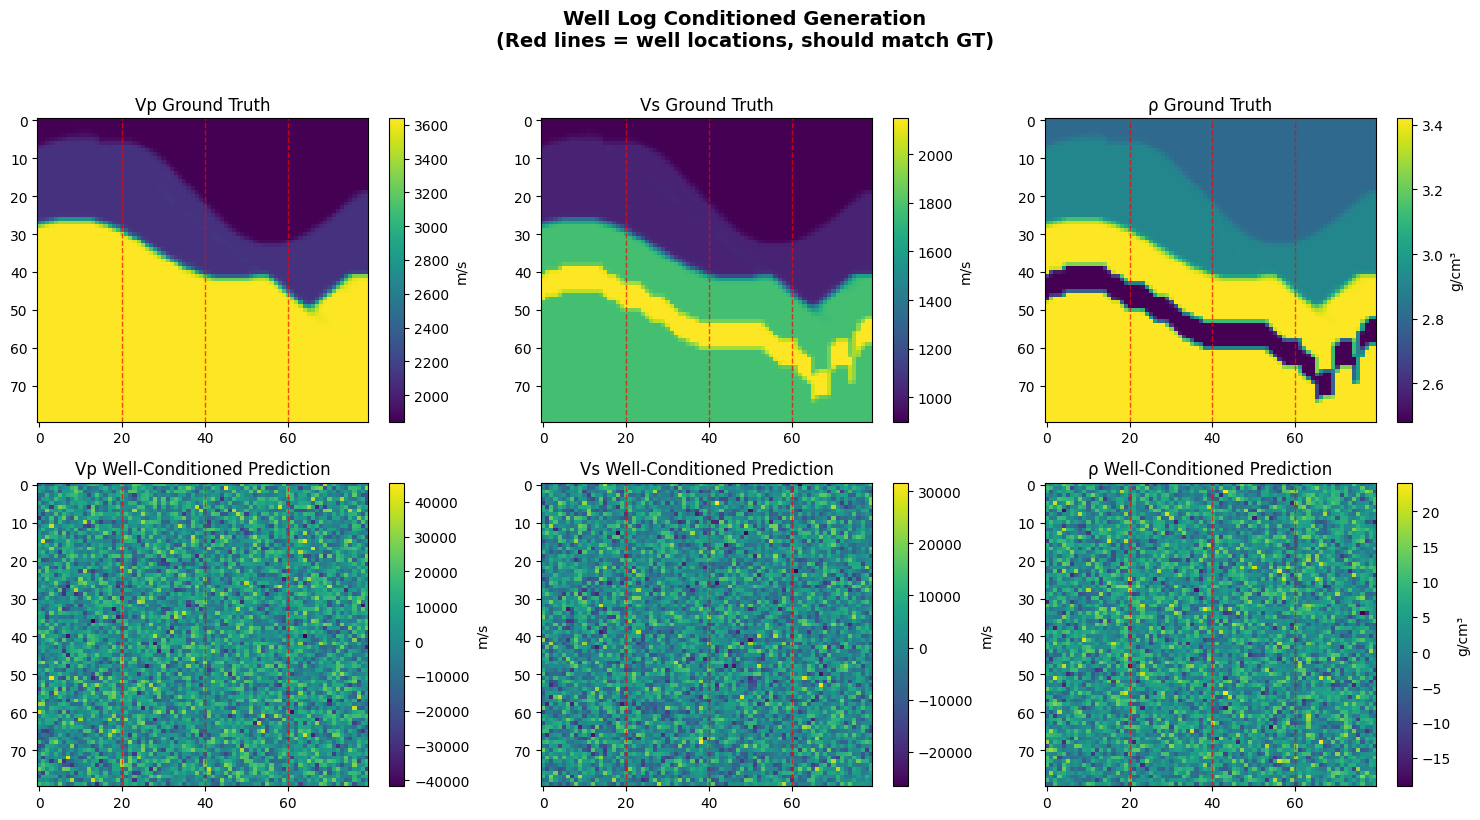

In [19]:
# =============================================================================
# VISUALIZE WELL-CONDITIONED GENERATION
# =============================================================================

if x_pred_well_phys is not None:
    # Take mean of ensemble (detach from computation graph first)
    vp_pred = x_pred_well_phys[:, 0].mean(dim=0).detach().numpy()
    vs_pred = x_pred_well_phys[:, 1].mean(dim=0).detach().numpy()
    rho_pred = x_pred_well_phys[:, 2].mean(dim=0).detach().numpy()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Ground truth
    for i, (arr, title, unit) in enumerate(zip([vp_gt, vs_gt, rho_gt], ['Vp', 'Vs', 'ρ'], ['m/s', 'm/s', 'g/cm³'])):
        im = axes[0, i].imshow(arr, cmap='viridis', aspect='auto', origin='upper')
        axes[0, i].set_title(f'{title} Ground Truth')
        for x in WELL_POSITIONS:
            axes[0, i].axvline(x=x, color='red', lw=1, ls='--', alpha=0.7)
        plt.colorbar(im, ax=axes[0, i], label=unit)
    
    # Predictions
    for i, (arr, title, unit) in enumerate(zip([vp_pred, vs_pred, rho_pred], ['Vp', 'Vs', 'ρ'], ['m/s', 'm/s', 'g/cm³'])):
        im = axes[1, i].imshow(arr, cmap='viridis', aspect='auto', origin='upper')
        axes[1, i].set_title(f'{title} Well-Conditioned Prediction')
        for x in WELL_POSITIONS:
            axes[1, i].axvline(x=x, color='red', lw=1, ls='--', alpha=0.7)
        plt.colorbar(im, ax=axes[1, i], label=unit)
    
    plt.suptitle('Well Log Conditioned Generation\n(Red lines = well locations, should match GT)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # # Check if well locations match
    # print('\n=== Well Location Accuracy ===')
    # for x in WELL_POSITIONS:
    #     vp_err = np.abs(vp_pred[:, x] - vp_gt[:, x]).mean()
    #     vs_err = np.abs(vs_pred[:, x] - vs_gt[:, x]).mean()
    #     print(f'Well x={x}: Vp MAE={vp_err:.1f} m/s, Vs MAE={vs_err:.1f} m/s')


## 9. Compute Metrics and Compare Results


In [44]:
def compute_metrics(pred: torch.Tensor, target: torch.Tensor) -> dict:
    """
    Compute RMSE and MAE metrics.
    
    Parameters
    ----------
    pred : torch.Tensor
        Predictions (can be ensemble)
    target : torch.Tensor
        Ground truth
        
    Returns
    -------
    dict
        Dictionary with RMSE and MAE values
    """
    # Use mean prediction if ensemble
    if pred.shape[0] > 1:
        pred_mean = pred.mean(dim=0, keepdim=True)
    else:
        pred_mean = pred
    
    rmse = torch.sqrt(torch.mean((pred_mean - target) ** 2)).item()
    mae = torch.mean(torch.abs(pred_mean - target)).item()
    
    return {"rmse": rmse, "mae": mae}


if x_pred_no_physics is not None:

    # Extract predictions by variable
    vp_pred_no_phys = x_pred_no_physics[:, 0:1]
    vs_pred_no_phys = x_pred_no_physics[:, 1:2]
    rho_pred_no_phys = x_pred_no_physics[:, 2:3]
    
    print("\nZero-Shot Sampling (No Physics):")
    for var_name, pred, true in [
        ("vp", vp_pred_no_phys, vp_true),
        ("vs", vs_pred_no_phys, vs_true),
        ("rho", rho_pred_no_phys, rho_true),
    ]:
        metrics = compute_metrics(pred, true)
        print(f"  {var_name}: RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}")
    
    if x_pred_with_physics is not None:
        vp_pred_phys = x_pred_with_physics[:, 0:1]
        vs_pred_phys = x_pred_with_physics[:, 1:2]
        rho_pred_phys = x_pred_with_physics[:, 2:3]
        
        print("\nPhysics-Informed Sampling (DPS):")
        for var_name, pred, true in [
            ("vp", vp_pred_phys, vp_true),
            ("vs", vs_pred_phys, vs_true),
            ("rho", rho_pred_phys, rho_true),
        ]:
            metrics = compute_metrics(pred, true)
            print(f"  {var_name}: RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}")



Zero-Shot Sampling (No Physics):
  vp: RMSE=2971.5142, MAE=2854.4194
  vs: RMSE=1492.8195, MAE=1425.5806
  rho: RMSE=4.0488, MAE=3.9755

Physics-Informed Sampling (DPS):
  vp: RMSE=2971.5159, MAE=2854.4197
  vs: RMSE=1492.8204, MAE=1425.5813
  rho: RMSE=4.0515, MAE=3.9782


/var/folders/lb/_fvxwgqj6xz7_8_phkhjf7vr0000gn/T/ipykernel_59570/4139477351.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rmse = torch.sqrt(torch.mean((pred_mean - target) ** 2)).item()
/var/folders/lb/_fvxwgqj6xz7_8_phkhjf7vr0000gn/T/ipykernel_59570/4139477351.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mae = torch.mean(torch.abs(pred_mean - target)).item()


## 10. Visualize Results


In [20]:
def plot_comparison(
    true: np.ndarray,
    pred_no_physics: np.ndarray,
    pred_with_physics: np.ndarray = None,
    var_name: str = "Variable",
    units: str = "",
):
    """
    Plot comparison between ground truth and predictions.
    
    Parameters
    ----------
    true : np.ndarray
        Ground truth
    pred_no_physics : np.ndarray
        Prediction without physics (ensemble mean)
    pred_with_physics : np.ndarray, optional
        Prediction with physics (ensemble mean)
    var_name : str
        Variable name for title
    units : str
        Units for colorbar label (e.g., 'm/s' for velocity)
    """
    n_cols = 3 if pred_with_physics is None else 5
    fig, axes = plt.subplots(1, n_cols, figsize=(4.5 * n_cols, 4.5))
    
    # Compute common vmin/vmax for consistent coloring across model plots
    vmin = min(true.min(), pred_no_physics.min())
    vmax = max(true.max(), pred_no_physics.max())
    if pred_with_physics is not None:
        vmin = min(vmin, pred_with_physics.min())
        vmax = max(vmax, pred_with_physics.max())
    
    colorbar_label = f"{units}" if units else var_name
    
    # Ground truth
    im0 = axes[0].imshow(true.squeeze(), cmap="viridis", vmin=vmin, vmax=vmax, aspect="auto", origin="upper")
    axes[0].set_title(f"{var_name} - Ground Truth")
    cbar0 = plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    cbar0.set_label(colorbar_label)
    
    # Zero-shot prediction
    im1 = axes[1].imshow(pred_no_physics.squeeze(), cmap="viridis", vmin=vmin, vmax=vmax, aspect="auto", origin="upper")
    axes[1].set_title(f"{var_name} - Zero-Shot")
    cbar1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    cbar1.set_label(colorbar_label)
    
    # Error (zero-shot)
    error_no_phys = np.abs(true.squeeze() - pred_no_physics.squeeze())
    im_err = axes[2].imshow(error_no_phys, cmap="hot", aspect="auto", origin="upper")
    axes[2].set_title(f"{var_name} - Abs Error (Zero-Shot)")
    cbar_err = plt.colorbar(im_err, ax=axes[2], fraction=0.046, pad=0.04)
    cbar_err.set_label(f"Error ({units})" if units else "Error")
    
    if pred_with_physics is not None:
        # Physics-informed prediction
        im3 = axes[3].imshow(pred_with_physics.squeeze(), cmap="viridis", vmin=vmin, vmax=vmax, aspect="auto", origin="upper")
        axes[3].set_title(f"{var_name} - Physics-Informed")
        cbar3 = plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)
        cbar3.set_label(colorbar_label)
        
        # Error (physics-informed)
        error_phys = np.abs(true.squeeze() - pred_with_physics.squeeze())
        im_err2 = axes[4].imshow(error_phys, cmap="hot", aspect="auto", origin="upper")
        axes[4].set_title(f"{var_name} - Abs Error (Physics)")
        cbar_err2 = plt.colorbar(im_err2, ax=axes[4], fraction=0.046, pad=0.04)
        cbar_err2.set_label(f"Error ({units})" if units else "Error")
    
    for ax in axes:
        ax.set_xlabel("x (grid)")
        ax.set_ylabel("Depth (grid)")
    
    plt.tight_layout()
    return fig


Loading pre-generated predictions from saved data...
(The saved outputs are already properly denormalized to physical units)

✓ Using pre-generated predictions from the saved .npz file

Data ranges (all in physical units):
  Vp true: 1843.0 - 3638.0 m/s
  Vp pred: 1805.4 - 3683.8 m/s
  Vs true: 899.6 - 2146.7 m/s
  Vs pred: 878.5 - 2209.6 m/s
  ρ true:  2.48 - 3.42 g/cm³
  ρ pred:  2.48 - 3.44 g/cm³


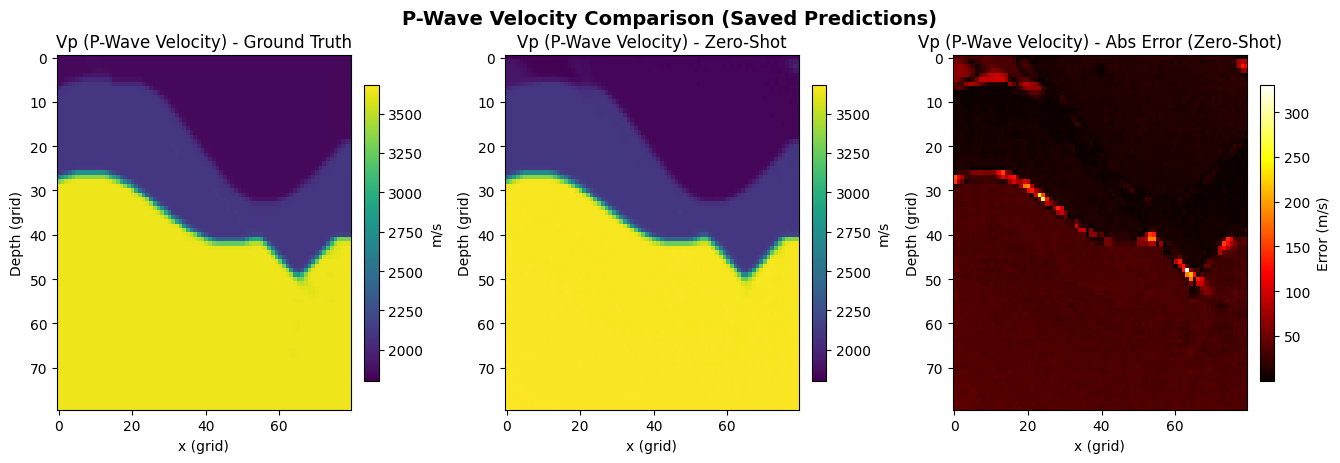

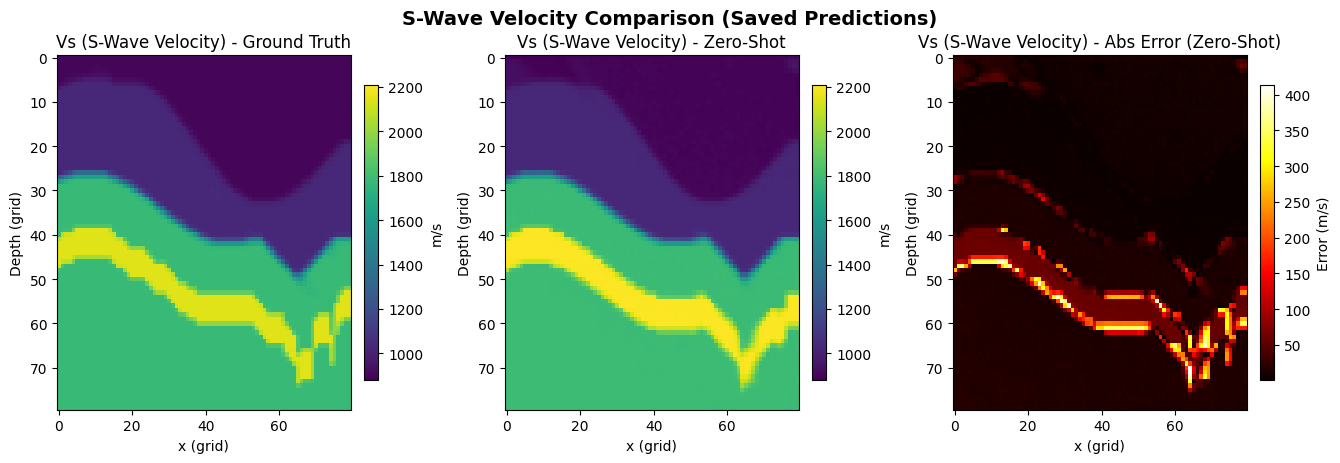

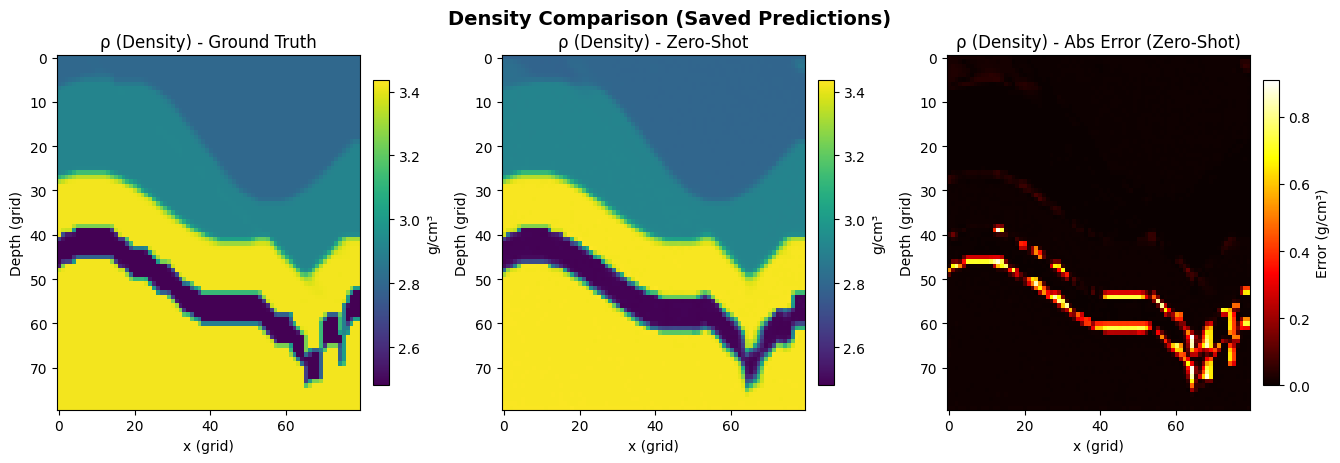

In [24]:
# Use pre-generated predictions from saved data (already correctly denormalized)
# The saved outputs from generate.py are properly denormalized to physical units
print("Loading pre-generated predictions from saved data...")
print("(The saved outputs are already properly denormalized to physical units)")

# Check if we have pre-generated predictions in sample_data
use_saved_predictions = "vp_mean" in sample_data and "vs_mean" in sample_data

if use_saved_predictions:
    print("\n✓ Using pre-generated predictions from the saved .npz file")
    
    # Use the saved predictions (already in physical units)
    vp_mean_pred = sample_data["vp_mean"].squeeze()
    vs_mean_pred = sample_data["vs_mean"].squeeze()
    rho_mean_pred = sample_data["rho_mean"].squeeze()
    
    # Ground truth (also in physical units)
    vp_true = sample_data["vp_true"][0, 0]
    vs_true = sample_data["vs_true"][0, 0]
    rho_true = sample_data["rho_true"][0, 0]
    
    print(f"\nData ranges (all in physical units):")
    print(f"  Vp true: {vp_true.min():.1f} - {vp_true.max():.1f} m/s")
    print(f"  Vp pred: {vp_mean_pred.min():.1f} - {vp_mean_pred.max():.1f} m/s")
    print(f"  Vs true: {vs_true.min():.1f} - {vs_true.max():.1f} m/s")
    print(f"  Vs pred: {vs_mean_pred.min():.1f} - {vs_mean_pred.max():.1f} m/s")
    print(f"  ρ true:  {rho_true.min():.2f} - {rho_true.max():.2f} g/cm³")
    print(f"  ρ pred:  {rho_mean_pred.min():.2f} - {rho_mean_pred.max():.2f} g/cm³")
    
    # Plot Vp comparison
    fig = plot_comparison(
        vp_true,
        vp_mean_pred,
        None,  # No physics-informed (use saved outputs from outputs_cond for physics)
        var_name="Vp (P-Wave Velocity)",
        units="m/s"
    )
    plt.suptitle("P-Wave Velocity Comparison (Saved Predictions)", y=1.02, fontsize=14, fontweight="bold")
    plt.show()
    
    # Plot Vs comparison
    fig = plot_comparison(
        vs_true,
        vs_mean_pred,
        None,
        var_name="Vs (S-Wave Velocity)",
        units="m/s"
    )
    plt.suptitle("S-Wave Velocity Comparison (Saved Predictions)", y=1.02, fontsize=14, fontweight="bold")
    plt.show()
    
    # Plot Rho comparison (note: density is in g/cm³, not kg/m³!)
    fig = plot_comparison(
        rho_true,
        rho_mean_pred,
        None,
        var_name="ρ (Density)",
        units="g/cm³"
    )
    plt.suptitle("Density Comparison (Saved Predictions)", y=1.02, fontsize=14, fontweight="bold")
    plt.show()

else:
    print("\n⚠ Pre-generated predictions not found in saved data.")
    print("To get properly denormalized predictions, either:")
    print("1. Run generate.py with your dataset (which has stats.json)")
    print("2. Provide the correct normalization statistics from your dataset")


Loading data from: outputs_cond/sample_0/numpy/data.npz

=== Available keys ===
['vp_pred', 'vp_true', 'vp_mean', 'vp_std', 'vp_ensemble', 'vs_pred', 'vs_true', 'vs_mean', 'vs_std', 'vs_ensemble', 'rho_pred', 'rho_true', 'rho_mean', 'rho_std', 'rho_ensemble', 'vx', 'vz']

=== Data ranges (physical units) ===
Vp: true=1843-3638 m/s, pred=1805-3684 m/s
Vs: true=900-2147 m/s, pred=878-2210 m/s
ρ:  true=2.48-3.42 g/cm³, pred=2.48-3.44 g/cm³

VISUALIZATION OF SAVED PREDICTIONS


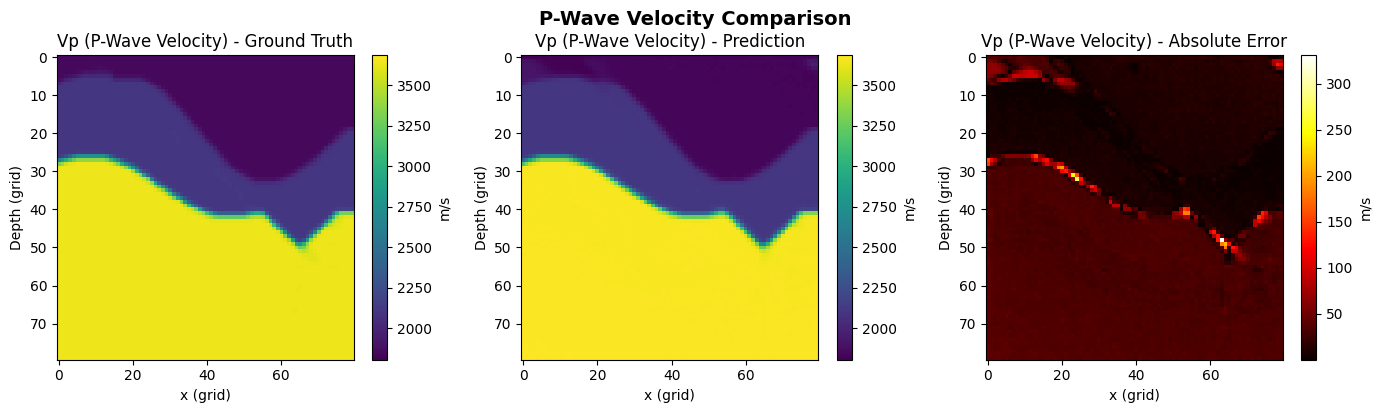

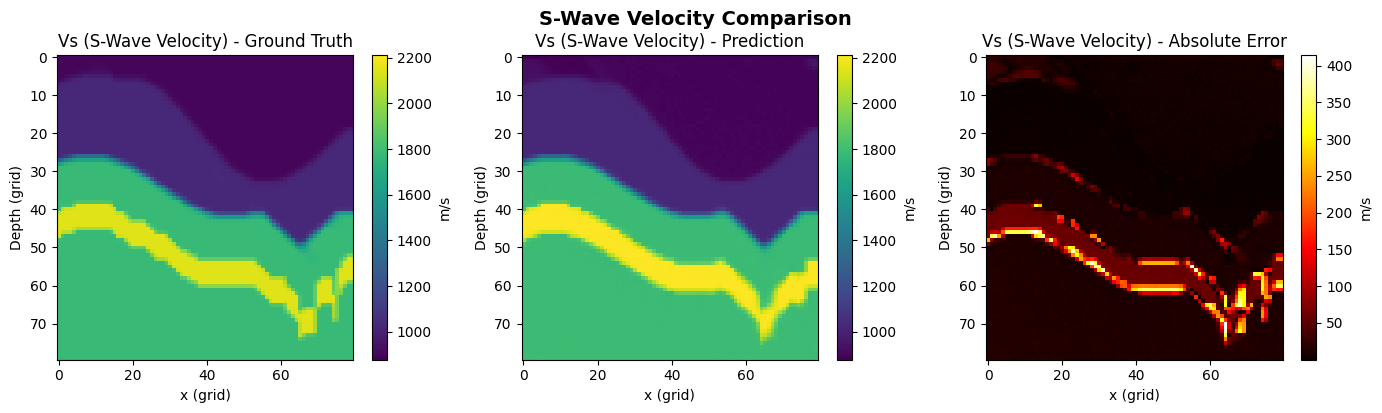

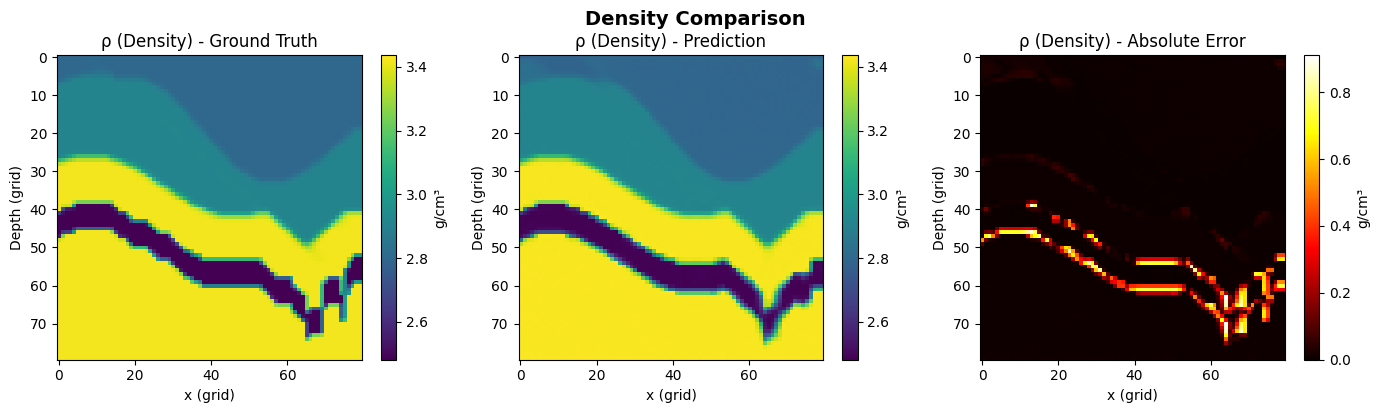


=== Metrics ===
RMSE Vp:  29.38 m/s
RMSE Vs:  53.92 m/s
RMSE ρ:   0.1108 g/cm³


In [25]:
# ============================================================================
# STANDALONE VISUALIZATION - Load and plot saved predictions directly
# Run this cell to visualize the pre-generated results without dependencies
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load saved data directly
data_path = Path("./outputs_cond/sample_0/numpy/data.npz")
print(f"Loading data from: {data_path}")
data = np.load(data_path)

print("\n=== Available keys ===")
print(list(data.keys()))

# Extract ground truth and predictions (already in physical units!)
vp_true = data["vp_true"].squeeze()
vs_true = data["vs_true"].squeeze()
rho_true = data["rho_true"].squeeze()

vp_pred = data["vp_mean"].squeeze()
vs_pred = data["vs_mean"].squeeze()
rho_pred = data["rho_mean"].squeeze()

print("\n=== Data ranges (physical units) ===")
print(f"Vp: true={vp_true.min():.0f}-{vp_true.max():.0f} m/s, pred={vp_pred.min():.0f}-{vp_pred.max():.0f} m/s")
print(f"Vs: true={vs_true.min():.0f}-{vs_true.max():.0f} m/s, pred={vs_pred.min():.0f}-{vs_pred.max():.0f} m/s")
print(f"ρ:  true={rho_true.min():.2f}-{rho_true.max():.2f} g/cm³, pred={rho_pred.min():.2f}-{rho_pred.max():.2f} g/cm³")

# Plot function
def simple_comparison(true, pred, title, units, cmap="viridis"):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    vmin = min(true.min(), pred.min())
    vmax = max(true.max(), pred.max())
    
    im0 = axes[0].imshow(true, cmap=cmap, vmin=vmin, vmax=vmax, aspect="auto", origin="upper")
    axes[0].set_title(f"{title} - Ground Truth")
    plt.colorbar(im0, ax=axes[0], label=units)
    
    im1 = axes[1].imshow(pred, cmap=cmap, vmin=vmin, vmax=vmax, aspect="auto", origin="upper")
    axes[1].set_title(f"{title} - Prediction")
    plt.colorbar(im1, ax=axes[1], label=units)
    
    error = np.abs(true - pred)
    im2 = axes[2].imshow(error, cmap="hot", aspect="auto", origin="upper")
    axes[2].set_title(f"{title} - Absolute Error")
    plt.colorbar(im2, ax=axes[2], label=units)
    
    for ax in axes:
        ax.set_xlabel("x (grid)")
        ax.set_ylabel("Depth (grid)")
    
    plt.tight_layout()
    return fig

# Plot all three variables
print("\n" + "="*60)
print("VISUALIZATION OF SAVED PREDICTIONS")
print("="*60)

fig = simple_comparison(vp_true, vp_pred, "Vp (P-Wave Velocity)", "m/s")
plt.suptitle("P-Wave Velocity Comparison", y=1.02, fontsize=14, fontweight="bold")
plt.show()

fig = simple_comparison(vs_true, vs_pred, "Vs (S-Wave Velocity)", "m/s")
plt.suptitle("S-Wave Velocity Comparison", y=1.02, fontsize=14, fontweight="bold")
plt.show()

fig = simple_comparison(rho_true, rho_pred, "ρ (Density)", "g/cm³")
plt.suptitle("Density Comparison", y=1.02, fontsize=14, fontweight="bold")
plt.show()

# Compute and print metrics
print("\n=== Metrics ===")
rmse_vp = np.sqrt(np.mean((vp_true - vp_pred)**2))
rmse_vs = np.sqrt(np.mean((vs_true - vs_pred)**2))
rmse_rho = np.sqrt(np.mean((rho_true - rho_pred)**2))
print(f"RMSE Vp:  {rmse_vp:.2f} m/s")
print(f"RMSE Vs:  {rmse_vs:.2f} m/s")
print(f"RMSE ρ:   {rmse_rho:.4f} g/cm³")

## 11. Visualize Ensemble Uncertainty


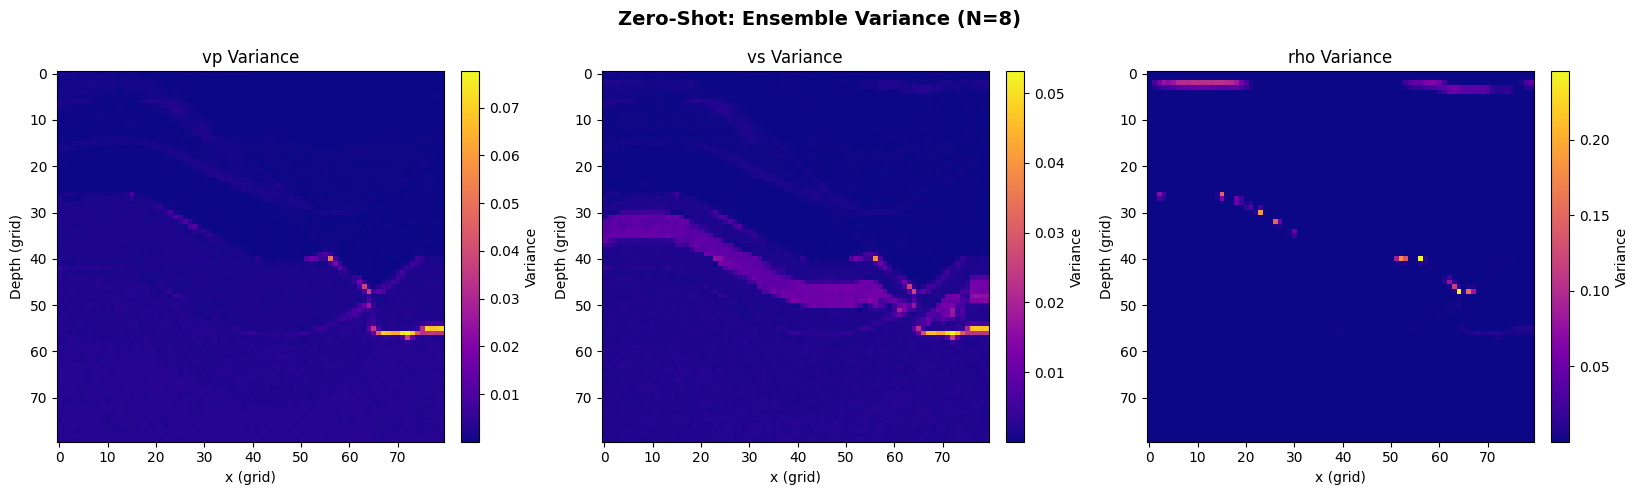

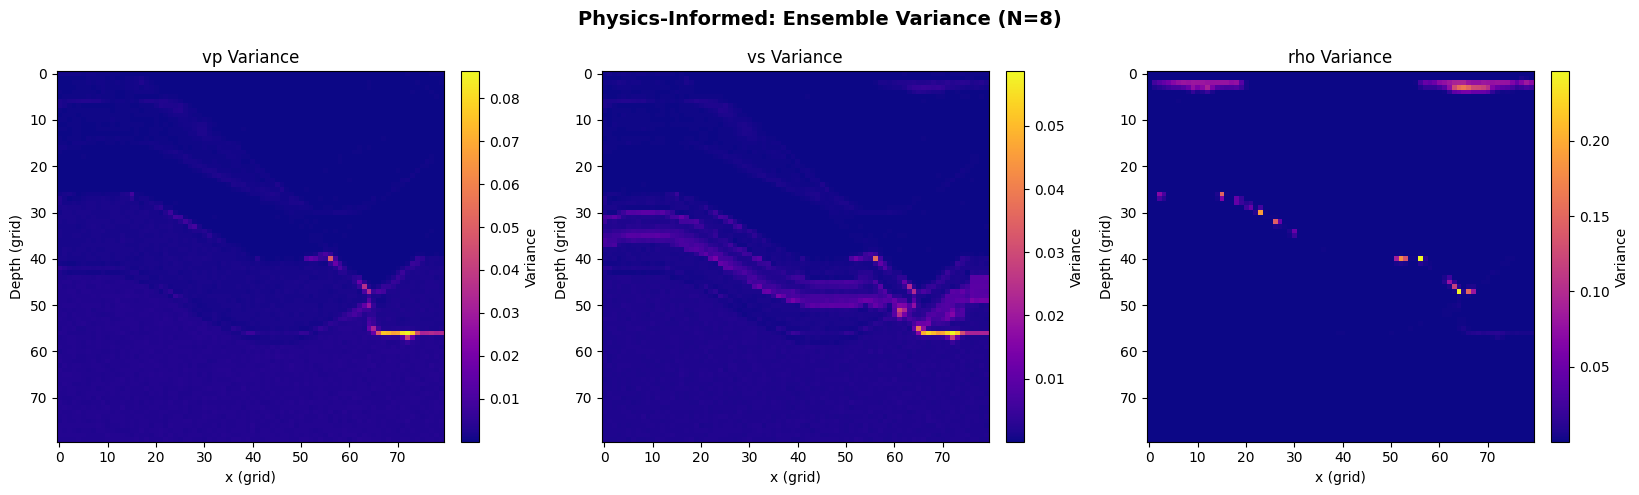

In [26]:
def plot_ensemble_variance(predictions: torch.Tensor, var_names: list, title_prefix: str = "", units_list: list = None):
    """
    Plot ensemble variance for each variable.
    
    Parameters
    ----------
    predictions : torch.Tensor
        Ensemble predictions (N, C, H, W)
    var_names : list
        Names of variables
    title_prefix : str
        Prefix for plot title
    units_list : list, optional
        Units for each variable (e.g., ['m/s', 'm/s', 'kg/m³'])
    """
    n_vars = len(var_names)
    if units_list is None:
        units_list = [""] * n_vars
    
    fig, axes = plt.subplots(1, n_vars, figsize=(5.5 * n_vars, 5))
    if n_vars == 1:
        axes = [axes]
    
    for i, (ax, var_name) in enumerate(zip(axes, var_names)):
        var_data = predictions[:, i].numpy()
        variance = np.var(var_data, axis=0)
        
        im = ax.imshow(variance.squeeze(), cmap="plasma", aspect="auto", origin="upper")
        ax.set_title(f"{var_name} Variance")
        ax.set_xlabel("x (grid)")
        ax.set_ylabel("Depth (grid)")
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        units = units_list[i] if i < len(units_list) else ""
        cbar.set_label(f"Var ({units}²)" if units else "Variance")
    
    plt.suptitle(f"{title_prefix}Ensemble Variance (N={predictions.shape[0]})", fontsize=14, fontweight="bold")
    plt.tight_layout()
    return fig


if x_pred_no_physics is not None:
    # Plot variance for zero-shot
    fig = plot_ensemble_variance(x_pred_no_physics, X_VARS, "Zero-Shot: ")
    plt.show()
    
    if x_pred_with_physics is not None:
        # Plot variance for physics-informed
        fig = plot_ensemble_variance(x_pred_with_physics, X_VARS, "Physics-Informed: ")
        plt.show()


## 12. Save Results


In [ ]:
if x_pred_no_physics is not None:
    print(f"Saving results to {OUTPUT_DIR}...")
    
    # Save zero-shot results
    save_data = {
        "vp_pred_no_physics": x_pred_no_physics[:, 0].numpy(),
        "vs_pred_no_physics": x_pred_no_physics[:, 1].numpy(),
        "rho_pred_no_physics": x_pred_no_physics[:, 2].numpy(),
        "vp_true": sample_data["vp_true"],
        "vs_true": sample_data["vs_true"],
        "rho_true": sample_data["rho_true"],
        "vx_input": sample_data["vx"],
        "vz_input": sample_data["vz"],
    }
    
    if x_pred_with_physics is not None:
        save_data.update({
            "vp_pred_with_physics": x_pred_with_physics[:, 0].numpy(),
            "vs_pred_with_physics": x_pred_with_physics[:, 1].numpy(),
            "rho_pred_with_physics": x_pred_with_physics[:, 2].numpy(),
        })
    
    np.savez_compressed(OUTPUT_DIR / f"sample_{sample_idx}_results.npz", **save_data)
    print(f"✓ Saved to {OUTPUT_DIR / f'sample_{sample_idx}_results.npz'}")


## Summary

This notebook demonstrated:

1. **Loading pre-saved sample data** from the `outputs_cond` directory
2. **Loading a trained diffusion model** checkpoint
3. **Zero-shot sampling** - purely data-driven generation from the learned conditional distribution
4. **Physics-informed sampling (DPS)** - generation with wave equation-based guidance for improved physical consistency
5. **Comparison and visualization** of results between the two approaches

### Key Observations:

- **Zero-shot sampling** is faster but may produce results that don't perfectly satisfy the underlying physics
- **Physics-informed sampling** takes longer (due to PDE evaluations) but can produce more physically consistent results
- **Ensemble generation** allows uncertainty quantification through variance estimation

### Next Steps:

- Tune the physics guidance parameters (`scale`, `gamma`, `std`) for your specific dataset
- Experiment with different numbers of diffusion steps
- Try different ensemble sizes for better uncertainty estimates
- Use the trained model on new seismic observations
